In [4]:
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab8/A.jpg
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab8/B.jpg
!ls

A.jpg  B.jpg  sample_data


In [0]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

def fwt97_2d(m, nlevels=1):
    ''' Perform the CDF 9/7 transform on a 2D matrix signal m.
    nlevel is the desired number of times to recursively transform the 
    signal. '''
    
    w = len(m[0])
    h = len(m)
    for i in range(nlevels):
        m = fwt97(m, w, h) # cols
        m = fwt97(m, w, h) # rows
        w = int(w/2)
        h = int(h/2)
    
    return m
    
def iwt97_2d(m, nlevels=1):
    ''' Inverse CDF 9/7 transform on a 2D matrix signal m.
        nlevels must be the same as the nlevels used to perform the fwt.
    '''
    
    w = len(m[0])
    h = len(m)

    # Find starting size of m:
    for i in range(nlevels-1):
        w = int(w/2)
        h = int(h/2)
        
    for i in range(nlevels):
        m = iwt97(m, w, h) # rows
        m = iwt97(m, w, h) # cols
        h *= 2
        w *= 2
    
    return m


def fwt97(s, width, height):
    ''' Forward Cohen-Daubechies-Feauveau 9 tap / 7 tap wavelet transform   
    performed on all columns of the 2D n*n matrix signal s via lifting.
    The returned result is s, the modified input matrix.
    The highpass and lowpass results are stored on the left half and right
    half of s respectively, after the matrix is transposed. '''
        
    # 9/7 Coefficients:
    a1 = -1.586134342
    a2 = -0.05298011854
    a3 = 0.8829110762
    a4 = 0.4435068522
    
    # Scale coeff:
    k1 = 0.81289306611596146 # 1/1.230174104914
    k2 = 0.61508705245700002 # 1.230174104914/2
    # Another k used by P. Getreuer is 1.1496043988602418
        
    for col in range(width): # Do the 1D transform on all cols:
        ''' Core 1D lifting process in this loop. '''
        ''' Lifting is done on the cols. '''
        
        # Predict 1. y1
        for row in range(1, height-1, 2):
            s[row][col] += a1 * (s[row-1][col] + s[row+1][col])   
        s[height-1][col] += 2 * a1 * s[height-2][col] # Symmetric extension
        
        # Update 1. y0
        for row in range(2, height, 2):
            s[row][col] += a2 * (s[row-1][col] + s[row+1][col])
        s[0][col] +=  2 * a2 * s[1][col] # Symmetric extension
        
        # Predict 2.
        for row in range(1, height-1, 2):
            s[row][col] += a3 * (s[row-1][col] + s[row+1][col])
        s[height-1][col] += 2 * a3 * s[height-2][col]
        
        # Update 2.
        for row in range(2, height, 2):
            s[row][col] += a4 * (s[row-1][col] + s[row+1][col])
        s[0][col] += 2 * a4 * s[1][col]
                
    # de-interleave
    temp_bank = [[0]*width for i in range(height)]
    for row in range(height):
        for col in range(width):
            # k1 and k2 scale the vals
            # simultaneously transpose the matrix when deinterleaving
            if row % 2 == 0: # even
                temp_bank[col][int(row/2)] = k1 * s[row][col]
            else:            # odd
                temp_bank[col][int(row/2) + int(height/2)] = k2 * s[row][col]
                
    # write temp_bank to s:
    for row in range(width):
        for col in range(height):
            s[row][col] = temp_bank[row][col]
                
    return s


def iwt97(s, width, height):
    ''' Inverse CDF 9/7. '''
    
    # 9/7 inverse coefficients:
    a1 = 1.586134342
    a2 = 0.05298011854
    a3 = -0.8829110762
    a4 = -0.4435068522
    
    # Inverse scale coeffs:
    k1 = 1.230174104914
    k2 = 1.6257861322319229
    
    # Interleave:
    temp_bank = [[0]*width for i in range(height)]
    for col in range(int(width/2)):
        for row in range(height):
            # k1 and k2 scale the vals
            # simultaneously transpose the matrix when interleaving
            temp_bank[col * 2][row] = k1 * s[row][col]
            temp_bank[col * 2 + 1][row] = k2 * s[row][col + int(width/2)]
                
    # write temp_bank to s:
    for row in range(width):
        for col in range(height):
            s[row][col] = temp_bank[row][col]

                
    for col in range(width): # Do the 1D transform on all cols:
        ''' Perform the inverse 1D transform. '''
        
        # Inverse update 2.
        for row in range(2, height, 2):
            s[row][col] += a4 * (s[row-1][col] + s[row+1][col])
        s[0][col] += 2 * a4 * s[1][col]
        
        # Inverse predict 2.
        for row in range(1, height-1, 2):
            s[row][col] += a3 * (s[row-1][col] + s[row+1][col])
        s[height-1][col] += 2 * a3 * s[height-2][col]

        # Inverse update 1.
        for row in range(2, height, 2):
            s[row][col] += a2 * (s[row-1][col] + s[row+1][col])
        s[0][col] +=  2 * a2 * s[1][col] # Symmetric extension
        
        # Inverse predict 1.
        for row in range(1, height-1, 2):
            s[row][col] += a1 * (s[row-1][col] + s[row+1][col])   
        s[height-1][col] += 2 * a1 * s[height-2][col] # Symmetric extension
                
    return s


def seq_to_img(m, pix):
    ''' Copy matrix m to pixel buffer pix.
    Assumes m has the same number of rows and cols as pix. '''
    for row in range(len(m)):
        for col in range(len(m[row])):
            pix[col,row] = m[row][col]
            
#---------------------------------------------------------------
#------------- WaveletFusion function --------------------------
#------- You need to modify this function-----------------------
#---------------------------------------------------------------
def  WaveletFusion(C1, C2):
   # input: C1, C2 = h by w matrix, wavelet transform of a image channel
    # h by w image height and width respectively
    # output: return the h by w array, fusion of C1 and C2
    
    # 1. create a new matrix C.
    C = np.zeros(C1.shape)

    # C(i,j) = C1(i,j), if absolute(C1(i,j)) > absolute(C2(i,j)) 
    # else  C(i,j) = C2(i,j)

    for i in range(h):
      for j in range(w):
        if abs(C1[i][j]) > abs(C2[i][j]):
          (C[i][j]) = (C1[i][j])
        else:
          (C[i][j]) = (C2[i][j])

    # 2. Top left sub-matrix elements of C (125 by 125) will be the
    # average of C1 and C2 (Top left sub-matrix)
    dim = 125
    for i in range(dim):
      for j in range (dim):
        C[i][j]= ((C1[i][j]) + (C2[i][j])) /2
    # 3. return the C matrix
    # --------Write your code-------

    return C


In [0]:
file_imA = 'A.jpg'
file_imB = 'B.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken: 13.910858392715454 sec


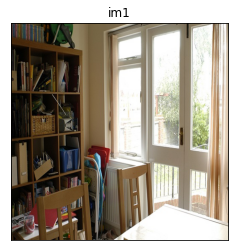

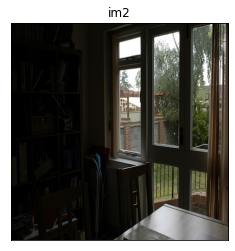

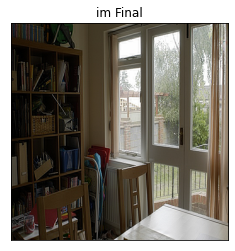

In [7]:
import time

start_t = time.time()

# Read and show the original image
im1 = Image.open(file_imA)
#print(im1.format, im1.size, im1.mode)
#print(len(im1.getbands()))
h, w = im1.size
im2 = Image.open(file_imB)


# Create an image buffer object for fast access.
pix1 = im1.load()
pix2 = im2.load()
im1_channels = im1.split()
im2_channels  = im2.split()

# Convert the 2d image to a 1d sequence:
im1_matrix = []
im2_matrix = []
for i in range(0,3):
  im1_matrix.append(list(im1_channels[i].getdata()))
  im2_matrix.append(list(im2_channels[i].getdata()))



# Convert the 1d sequence to a 2d matrix.
# Each sublist eprsents a row. Access is done via m[row][col].
for ind in range(0,3):
  im1_matrix[ind] = [im1_matrix[ind][i:i+im1.size[0]] for i in range(0, len(im1_matrix[ind]), im1.size[0])]
  im2_matrix[ind] = [im2_matrix[ind][i:i+im2.size[0]] for i in range(0, len(im2_matrix[ind]), im2.size[0])]


#-----------------------------------------------------
#You need to change the final_im_channels array
#
#--------------------------------------------------------

final_im_channels = np.zeros((h,w,3), dtype='int64')

for i in range(0,3):
  #-----------------------------------------------------------
  # Write your code here
  # 1. call fwt97_2d funtion to get wavelet signal for a image channel
  imgChannel_1 = fwt97_2d(im1_matrix[i], 3)
  imgChannel_2 = fwt97_2d(im2_matrix[i], 3)



  # 2. convert the type as numpy array
  arrayChannel_1 = np.array(imgChannel_1)
  arrayChannel_2 = np.array(imgChannel_2)

  # 3. call WaveletFusion to fuse two channels
  fusedChannels = WaveletFusion(arrayChannel_1,arrayChannel_2)

  # 2. call iwt97_2d function to get actual image channel
  actualImgChannel = iwt97_2d(fusedChannels,3)
  # 3. put it in final_im_channels array #final_im_channels[:,:,i] = channel
  #------------------------------------------------------------
  final_im_channels[:,:,i] = actualImgChannel
  
  
  
  
  #If you don't change final_im_channels[:,:,i] it will show you a black image

#----------------------------------------------------------------------
# You do not need to change the following code
# This code will show the images
#-----------------------------------------------------------------------
im_final = np.zeros((h,w,3), dtype='int64')
im_final[:,:,0] = final_im_channels[:,:,0]
im_final[:,:,1] = final_im_channels[:,:,1]
im_final[:,:,2] = final_im_channels[:,:,2]


plt.figure()
plt.imshow(im1, cmap = plt.get_cmap('brg'), vmin = 0, vmax = 255)
plt.title('im1')
plt.xticks([]), plt.yticks([])

plt.figure()
plt.imshow(im2)
plt.title('im2')
plt.xticks([]), plt.yticks([])

plt.figure()
plt.imshow(im_final)
plt.title('im Final')
plt.xticks([]), plt.yticks([])


end_t = time.time()

print('Time taken: {} sec'.format(end_t - start_t))
